In [2]:
import gzip
import json
import pickle
import os
from loguru import logger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
import geopandas as gpd

import numpy as np
import pandas as pd

from ppgmne_prf.config.paths import PATH_DATA_SOLVER_DETAILS, PATH_DATA_SOLVER_RESULTS, PATH_DATA_IBGE_UF, PATH_DATA_CACHE
from ppgmne_prf.utils import get_distance_matrix
from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess_accidents, preprocess, preprocess_stations
from ppgmne_prf.utils import clean_string

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [15, 8]

sns.set_palette('deep')
PALETTE = sns.color_palette()

MAP_COLOR = '#d1cab2'
SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')

In [26]:
# Funções úteis:

def get_df_results(df_results, p=None, q=None):
    if p is None:
        df_out = df_results[(df_results['q'] == q)].copy()
    if q is None:
        df_out = df_results[(df_results['p'] == p)].copy()
    df_out['obj_function_abs_diff'] = abs(df_out['obj_function'].diff().fillna(0))
    df_out['obj_function_abs_pct_change'] = abs(df_out['obj_function'].pct_change().fillna(0))*100
    df_out['obj_function_abs_pct_change'] = np.where(
        df_out['obj_function_abs_pct_change'] == 0, 
        np.nan, 
        df_out['obj_function_abs_pct_change']
    )
    return df_out

def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out


def preproccess_muns(df_muns):
    cols = ['municipio', 'microrregiao', 'mesorregiao', 'regiao_imediata']
    cols_en = ['municipality', 'microregion', 'mesoregion', 'immediate_region', 'mun_name_orig']
    df_out = df_muns[cols].copy()
    df_out['mun_name_orig'] = df_out['municipio']

    for col in cols:
        df_out = clean_string(df=df_out, target=col, mode='upper')

    df_out.columns = cols_en
    return df_out


def get_all_results():
    output_dict = None

    for file in os.listdir(PATH_DATA_SOLVER_RESULTS):
        if file.split(".")[-1] == "json":
            with open(PATH_DATA_SOLVER_RESULTS / file) as file:
                dict_result = json.load(file)
            if output_dict is None:
                output_dict = dict_result
                for key in dict_result:
                    output_dict[key] = [dict_result[key]]
            else:
                for key in dict_result:
                    output_dict[key].append(dict_result[key])

    df_out = pd.DataFrame(output_dict)
    df_out = df_out.sort_values(['p', 'q']).reset_index(drop=True)
    return df_out


def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=2.5,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função objetivo (Z)',
    p2_ylabel='Decrescimento percentual de Z com relação ao p anterior',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=PALETTE,
    arrow_txt="p = 36",
    arrow_xy=(35.7, 2.25),
    arrow_txt_xy=(20, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()


def get_uops_by_sol(df_feasibles):
    dict_sols = {'p': [], 'q': [], 'name': []}

    for row in df_feasibles.itertuples():
        df_sol = get_solution_details(p=row.p, q=row.q)
        uops = list(df_sol[df_sol['is_median'] == 1]['name'])
        dict_sols['p'] = dict_sols['p'] + [row.p]*len(uops)
        dict_sols['q'] = dict_sols['q'] + [row.q]*len(uops)
        dict_sols['name'] = dict_sols['name'] + uops

    return pd.DataFrame(dict_sols)


def agg_uops(df, p=None, q=None):
    if p is not None:
        df = df[df['p'] == p].copy()
    if q is not None:
        df = df[df['q'] == q].copy()
    df_out = df.groupby('name').agg(n=('name', 'count')).reset_index()
    return df_out


def merge_uops(df, df_agg):
    df_out = df.merge(df_agg, how='left', on='name')
    df_out['n'] = df_out['n'].fillna(0)
    df_out = df_out.sort_values(by='n', ascending=False).reset_index(drop=True)
    return df_out


def agg_and_merge_uops(df_uops_base, df_uops_by_sols, n_total, q=None, p=None):

    df_agg = agg_uops(df_uops_by_sols, p=p, q=q)
    df_out = merge_uops(df_uops_base, df_agg)
    df_out['pct_solutions'] = df_out['n'] / n_total * 100

    # Cria colunas para gerar tabelas latex
    df_out['UOP'] = df_out['name']
    df_out['Município'] = df_out['mun_name_orig']
    df_out['Atual'] = df_out['is_uop'].apply(lambda x: "Sim" if x == True else "Não")
    df_out['Soluções'] = df_out['n'].astype(int).astype(str) + " (" + df_out['pct_solutions'].round(0).astype(int).astype(str) + "%)"

    return df_out


def plot_uops_by_sol(df_plot, range_p, figsize=(15,8), grid=False):
    plt.subplots(figsize=figsize)

    sns.scatterplot(df_plot, x='p', y='name', s=180)
    plt.xticks(range_p)
    plt.xlabel("Número de UOPs a serem instaladas (p)", fontsize=14)
    plt.ylabel("")

    if grid:
        plt.grid()
        
    plt.savefig('foo.png')   
    plt.show()


def get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=None):
    df_sol = get_solution_details(q, p)
    fo_orig = df_sol['obj_function'].sum()


    uop_proposta_lat = df_sol[df_sol['name'] == uop_proposta]['latitude'].max()
    uop_proposta_lon = df_sol[df_sol['name'] == uop_proposta]['longitude'].max()
    df_sol['is_median'] = np.where(df_sol['name'].isin([uop_alocada, uop_proposta]), ~df_sol['is_median'], df_sol['is_median'])
    df_sol['median_name'] = np.where(df_sol['median_name'] == uop_alocada, uop_proposta, df_sol['median_name'])
    df_sol['median_lat'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lat, df_sol['median_lat'])
    df_sol['median_lon'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lon, df_sol['median_lon'])
    df_sol['distance_q_to_m'] = df_sol.apply(lambda x: haversine(point1=(x['latitude'], x['longitude']), point2=(x['median_lat'], x['median_lon'])), axis=1)
    df_sol['obj_function'] = df_sol['distance_q_to_m'] * df_sol['n_accidents']

    fo_new = df_sol['obj_function'].sum()
    if last_fo_dif is not None:
        fo_orig = fo_orig + last_fo_dif
        fo_new = fo_new + last_fo_dif

    df_dist = df_sol[df_sol['name'].isin([uop_alocada, uop_proposta])]
    dist_matrix = get_distance_matrix(
        df_dist["latitude"], df_dist["longitude"], df_dist["latitude"], df_dist["longitude"]
    )
    dist = dist_matrix.max()

    logger.info(f"FO inicial: {fo_orig}")
    logger.info(f"FO final: {fo_new}")
    logger.info(f"Variação da FO: {fo_new - fo_orig} | {round((fo_new - fo_orig)/fo_orig*100,2)}%")
    logger.info(f"Distância entre {uop_alocada} e {uop_proposta}: {round(dist,2)}km")

    return df_sol


def plot_solutions_map(q, p, x='longitude', y='latitude', xlab="Longitude", ylab="Latitude", figsize=(15,8), fontsize=14):
    df_sol = get_solution_details(q=q, p=p)

    df_accidents = df_sol.dropna()
    df_accidents['Quadrante'] = "Acidente"

    df_uops = df_sol[df_sol['is_median'] == True].copy()
    df_uops['Quadrante'] = "UOP"

    cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
    df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
    df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)

    fig, ax = plt.subplots(figsize=figsize)
    SHAPE.plot(ax = ax, color = MAP_COLOR)
    p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
    p.set_xlabel(xlab, fontsize=fontsize)
    p.set_ylabel(ylab, fontsize=fontsize)

    legend_name="" 
    plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

    for row in df.itertuples():
        lat0 = row.latitude
        lat1 = row.median_lat
        lon0 = row.longitude
        lon1 = row.median_lon
        x = (lon0, lon1)
        y = (lat0, lat1)
        plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

    plt.savefig('foo.png')   
    plt.show()


In [4]:
# Carrega as informações dos municípios (IBGE)

df_muns = pd.read_pickle(PATH_DATA_CACHE / "df_municipios_ibge.pkl")
df_muns = preproccess_muns(df_muns)
df_muns.head()

,municipality,microregion,mesoregion,immediate_region,mun_name_orig
0,ABATIA,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA,Abatiá
1,ADRIANOPOLIS,CERRO AZUL,METROPOLITANA DE CURITIBA,CURITIBA,Adrianópolis
2,AGUDOS DO SUL,RIO NEGRO,METROPOLITANA DE CURITIBA,CURITIBA,Agudos do Sul
3,ALMIRANTE TAMANDARE,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Almirante Tamandaré
4,ALTAMIRA DO PARANA,GOIOERE,CENTRO OCIDENTAL PARANAENSE,CAMPO MOURAO,Altamira do Paraná


In [5]:
df_muns.shape

(399, 5)

In [6]:
# Carrega os dados pré-modelagem:

df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)
df_quadrants.head()

2023-08-08 20:49:34.928 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-08-08 20:49:34.929 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-08-08 20:49:34.930 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-08-08 20:49:35.111 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-08-08 20:49:35.112 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-08-08 20:49:35.112 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-08-08 20:49:35.113 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-08-08 20:49:35.113 | INFO     | ppgmne_prf.preproces

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
0,-23.2000,-52.3000,ALTO PARANA,ALTO PARANA 01,20.0000,0.0000,5.0000,1.0000,4.0000,1,180.0000,False,False
1,-24.8000,-52.3000,PALMITAL,PALMITAL 03,1.0000,0.0000,1.0000,1.0000,0.0000,1,180.0000,False,False
2,-24.9000,-52.2000,PALMITAL,PALMITAL 02,5.0000,0.0000,0.0000,3.0000,2.0000,1,180.0000,False,False
3,-24.9000,-52.3000,PALMITAL,PALMITAL 01,3.0000,0.0000,1.0000,1.0000,1.0000,1,180.0000,False,False
4,-25.3000,-49.8000,PALMEIRA,PALMEIRA 09,10.0000,0.0000,2.0000,1.0000,0.0000,1,180.0000,False,False


In [7]:
# Cria tabela com informações cadastrais por UOP:

df_uops_base = df_quadrants[['name', 'municipality', 'is_uop', 'n_accidents']].copy()
df_uops_base = df_uops_base.merge(df_muns, how='left', on='municipality')
df_uops_base.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig
0,ALTO PARANA 01,ALTO PARANA,False,20.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,Alto Paraná
1,PALMITAL 03,PALMITAL,False,1.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
2,PALMITAL 02,PALMITAL,False,5.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
3,PALMITAL 01,PALMITAL,False,3.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
4,PALMEIRA 09,PALMEIRA,False,10.0000,PONTA GROSSA,CENTRO ORIENTAL PARANAENSE,PONTA GROSSA,Palmeira


In [8]:
df_uops_base.shape

(419, 8)

In [9]:
df_uops_base.isna().sum()

name                0
municipality        0
is_uop              0
n_accidents         1
microregion         0
mesoregion          0
immediate_region    0
mun_name_orig       0
dtype: int64

In [10]:
# Carrega os resultados:
df_all_results = get_all_results()

In [11]:
df_all_results.shape

(2192, 7)

In [12]:
# Confere os resultados:
df_all_results.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,1,2,0,1
1,2,3,0,2
2,3,4,0,3
3,4,5,0,4
4,5,6,0,5
5,6,7,0,6
6,7,8,0,7
7,8,9,0,8
8,9,10,0,9
9,10,11,0,10


In [13]:
P = [p for p in range(1, 80+1)]
Q = [q for q in range(0, 33+1)]
PQ = [(p,q) for p in P for q in Q if q <= p]
len(PQ)

2192

In [14]:
# Somente soluções factíveis:
df_feasibles = df_all_results[df_all_results['is_feasible'] == True].copy()
df_feasibles.head()

,name,p,q,solver,is_feasible,is_optimal,obj_function
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487
15,model_p5_q1_results,5,1,gurobi,True,True,1716762.1879
16,model_p5_q2_results,5,2,gurobi,True,True,1727546.4304
17,model_p5_q3_results,5,3,gurobi,True,True,1839403.3324
18,model_p5_q4_results,5,4,gurobi,True,True,2031810.1194


In [15]:
# confere os resultados factíveis:
df_feasibles.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,5,5,0,4
1,6,7,0,6
2,7,8,0,7
3,8,9,0,8
4,9,10,0,9
5,10,11,0,10
6,11,12,0,11
7,12,13,0,12
8,13,14,0,13
9,14,15,0,14


In [16]:
F = [(p,q) for p in P for q in Q if q < p-1 and p >= 5]
len(F)

2119

In [17]:
df_feasibles.shape

(2177, 7)

In [18]:
# Soluções livres
df_results_q0 = get_df_results(df_all_results, q=0)
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
5,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
9,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487,1715898.5487,inf
20,model_p6_q0_results,6,0,gurobi,True,True,1499386.2742,216512.2746,12.6180
27,model_p7_q0_results,7,0,gurobi,True,True,1339785.9895,159600.2846,10.6444
35,model_p8_q0_results,8,0,gurobi,True,True,1243477.9222,96308.0673,7.1883
44,model_p9_q0_results,9,0,gurobi,True,True,1153093.5795,90384.3427,7.2687
54,model_p10_q0_results,10,0,gurobi,True,True,1080655.7591,72437.8204,6.2820


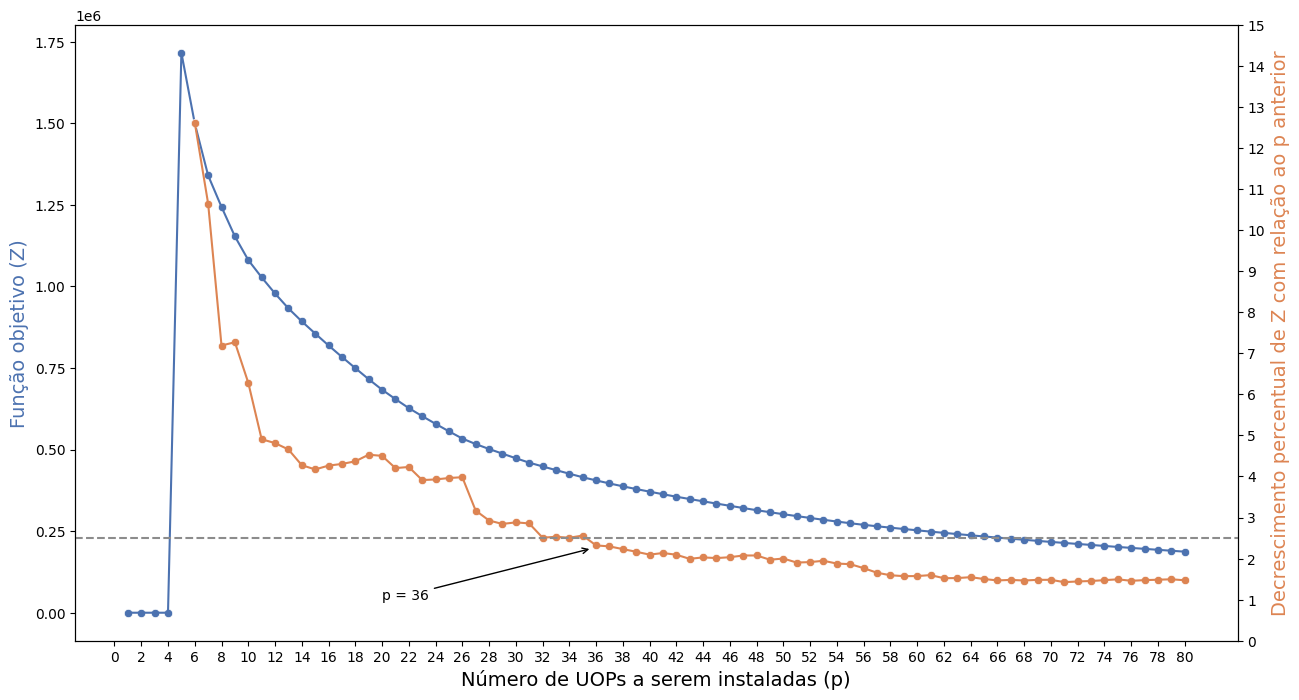

In [27]:
plot_fo(df_results_q0, "p")

In [ ]:
df_results_q0

In [ ]:
# Verifica a distribuição das UOPs por solução factível:

df_uops_by_sols = get_uops_by_sol(df_feasibles)
df_uops_by_sols.head()

In [ ]:
df_uops_by_sols.shape

In [ ]:
# Filtra só o range desejado:

p = 36
range_p = [p for p in range(p, 50+1)]
print(range_p)
print(len(range_p))
df_uops_by_sols_range = df_uops_by_sols[df_uops_by_sols['p'].isin(range_p)].copy()
df_uops_by_sols_range.head()

In [ ]:
df_uops_all_range_q0 = agg_and_merge_uops(df_uops_base, df_uops_by_sols_range, len(range_p), q=0)

In [ ]:
df_uops_all_range_q0.head()

In [ ]:
df_uops_all_range_q0.shape

In [ ]:
# Quadrantes não usados
df_0 = df_uops_all_range_q0[df_uops_all_range_q0['pct_solutions'] == 0].copy()
df_0.shape

In [ ]:
df_0[df_0['is_uop'] == True].shape

In [ ]:
df_0[df_0['is_uop'] == False].shape

In [ ]:
df_choosen = df_uops_all_range_q0[(df_uops_all_range_q0['pct_solutions'] > 0)]
df_choosen.shape

In [ ]:
df_choosen_100 = df_choosen[df_choosen['pct_solutions'] == 100].copy()

In [ ]:
df_choosen_100_current = df_choosen_100[df_choosen_100['is_uop'] == True].copy()
df_choosen_100_current.shape

In [ ]:
df_choosen_100_current = df_choosen_100_current.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_current[''] = df_choosen_100_current.index+1
print(df_choosen_100_current[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

In [ ]:
df_choosen_100_candidate = df_choosen_100[df_choosen_100['is_uop'] == False].copy()
df_choosen_100_candidate.shape

In [ ]:
df_choosen_100_candidate = df_choosen_100_candidate.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_candidate[''] = df_choosen_100_candidate.index+1
print(df_choosen_100_candidate[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

In [ ]:
df_choosen_lt100 = df_choosen[df_choosen['pct_solutions'] < 100].copy()
df_choosen_lt100.shape

In [ ]:
df_choosen_lt100 = df_choosen_lt100.sort_values(by=['Atual', 'pct_solutions', 'Município', 'UOP'], ascending=[False, False, True, True]).reset_index(drop=True)
df_choosen_lt100[''] = df_choosen_lt100.index+1
print(df_choosen_lt100[['', 'UOP', 'Atual', 'Município', 'Soluções']].to_latex(index=False, multirow=True))

In [ ]:
# Considerando a solução p = 36 e q = 0...

df_plot = df_uops_by_sols_range[(df_uops_by_sols_range['p'].isin(range_p)) & (df_uops_by_sols_range['q'] == 0)].copy()
df_plot = df_plot[df_plot['name'].isin(df_choosen_lt100['name'])].copy()
df_plot.head()


In [ ]:
plot_uops_by_sol(df_plot, range_p)

In [ ]:
uop_alocada = "UOP02-DEL06-PR"
uop_proposta = "MARECHAL CANDIDO RONDON 04"
q = 0
p = 43
df_sol_43 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

In [ ]:
uop_alocada = "TIBAGI 03"
uop_proposta = "TIBAGI 04"
q = 0
p = 44
df_sol_44 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=1764.9940265885089)

In [ ]:
uop_alocada = "GUARANIACU 02"
uop_proposta = "GUARANIACU 01"
q = 0
p = 45
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=3185.2122763741645)

In [ ]:
uop_alocada = "CANDOI 05"
uop_proposta = "VIRMOND 01"
q = 0
p = 45
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=3760.4926771139726)

In [ ]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 48
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

In [ ]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 49
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

In [ ]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 50
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

In [ ]:
realoc = {
    "UOP02-DEL06-PR":"MARECHAL CANDIDO RONDON 04",
    "TIBAGI 03": "TIBAGI 04",
    "GUARANIACU 02": "GUARANIACU 01",
    "CANDOI 05": "VIRMOND 01",
    "GUARATUBA 03": "UOP04-DEL01-PR"
}

df_plot2 = df_plot[df_plot['p'].isin(range_p)]

df_plot2['name'] = np.where(
    df_plot2['name'].isin(realoc.keys()),
    df_plot2['name'].map(realoc),
    df_plot2['name']
)

plot_uops_by_sol(df_plot2, range_p)

In [ ]:
plot_solutions_map(q=0, p=39)

In [ ]:
df_uops_atuais = df_quadrants[df_quadrants['is_uop'] == True]

df_sol = get_solution_details(q=0, p=39)
uops_modelo = df_sol[df_sol['is_median'] == True]['name']
df_uops_modelo = df_quadrants[df_quadrants['name'].isin(uops_modelo)].copy()

In [ ]:
dist_matrix = get_distance_matrix(
    lat_rows=df_uops_modelo['latitude'],
    lon_rows=df_uops_modelo['longitude'],
    lat_cols=df_uops_atuais['latitude'],
    lon_cols=df_uops_atuais['longitude'],)

lst_idx = []
lst_dist = []
idx_to_ignore = []
for i in range(0, len(dist_matrix)):
    row = dist_matrix[i]
    min_dist = 999999999999
    min_index = 999999999999
    for j in range(0, len(row)):
        if i != j: # and j not in idx_to_ignore:
            if row[j] < min_dist:
                min_dist = row[j]
                min_index = list(row).index(row[j])
    lst_idx.append(min_index)
    lst_dist.append(min_dist)
    idx_to_ignore.append(min_index)

In [ ]:
df_dists = pd.DataFrame({'idx_j': lst_idx, 'dist': lst_dist})
df_dists['uop_i'] = [df_uops_modelo.iloc[u]['name'] for u in df_dists.index]
df_dists['uop_j'] = [df_uops_atuais.iloc[u]['name'] for u in df_dists['idx_j'] if u < 999999]
df_dists = df_dists.sort_values(by='dist').reset_index(drop=True)
df_dists['cum_count'] = df_dists.groupby(['uop_j']).cumcount()+1

In [ ]:
df_dists